# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Bixo Fredik"
student2 = "Mbanga Ndjock Pierre Armel"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import keras

Using TensorFlow backend.


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

### Plotting

In [4]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [5]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

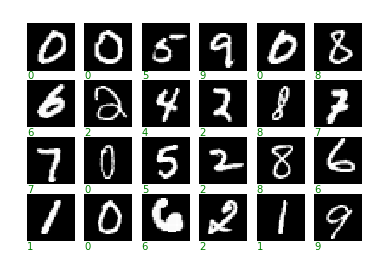

In [6]:
# Plot the digits
res = plot_some_samples(x_train, (y_train+9)%10)

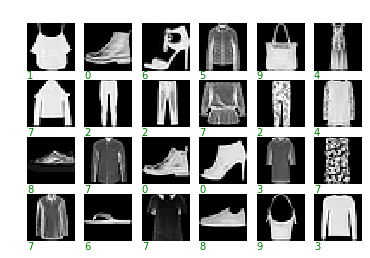

In [7]:
res = plot_some_samples(x_fashion_train, (y_fashion_train))

Answer to question 2: The green digits at the bottom left of each image indicate the labels associated to the image in the dataset !

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [10]:
datasets = [('MNIST', x_train, x_test, y_train, y_test), 
            ('Fashion-MNIST', x_fashion_train, x_fashion_test, y_fashion_train, y_fashion_test)]

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [11]:
from keras.callbacks import EarlyStopping

import pickle
from pathlib import Path
from os.path import join

In [12]:
def save(save_path, histories, summaries, scores):
    ok = True
    try:
        # Save Histories
        with open(join(save_path, Path('histories.pkl')), "wb") as f:
            pickle.dump(histories, f)
        # Save Summaries
        with open(join(save_path, Path('summaries.pkl')), "wb") as f:
            pickle.dump(summaries, f)
        # Save Scores
        with open(join(save_path, Path('scores.pkl')), "wb") as f:
            pickle.dump(scores, f)
    except Exception as e:
        print(e)
        ok = False
    return ok

In [13]:
def load(load_path):
    histories, summaries, scores = None, None, None
    try:
        # Load histories
        histories = pickle.load(open(join(load_path, Path('histories.pkl')), "rb" ))
        # Load summaries
        summaries = pickle.load(open(join(load_path, Path('summaries.pkl')), "rb" ))
        # Load summaries
        scores = pickle.load(open(join(load_path, Path('scores.pkl')), "rb" ))
    except Exception as e:
          print(e)
    
    return histories, summaries, scores

In [14]:
def create_model_exercice2():
    # Define model
    model = Sequential()
    # Use the softmax activation for the output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                  optimizer=SGD(lr=0.01), # Use stochastic gradient descent for the optimizer
                  metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [ ]:
# For more accurate estimates of the SGD
batch_size = 128
# Number of epochs for the training
epochs = 10000
# Number of classes
num_classes = 10
# define the patience for EarlyStopping
patience = 10
# Define Early Stopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [ ]:
# save histories, summaries and scores
histories, summaries, scores, models = {}, {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name], models[name] = {}, {}, {}, {}
    # Get the model
    model = create_model_exercice2()
    # Train the model
    history = model.fit(input_train, target_train,
                        batch_size=batch_size, # choose a minibatch of size 128
                        epochs=epochs, # Fit for as many epochs as needed to see no further decrease in the validation loss ??
                        verbose=1,
                        validation_data=(input_test, target_test),
                        callbacks=[es])
    # Update
    histories[name] = history
    summaries[name] = model.summary
    models[name] = model
    # Update scores
    test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
    scores[name] = {}
    scores[name]['test_loss'] = test_loss
    scores[name]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice2/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)
# save models
with open(join(save_path, Path('models.pkl')), "wb") as f:
    pickle.dump(models, f)

In [15]:
# Load path
load_path = Path('./save/exercice2/')
# Load histories
histories_2 , summaries_2, scores_2 = load(load_path)
# Load models
models_2 = pickle.load(open(join(load_path, Path('models.pkl')), "rb" ))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


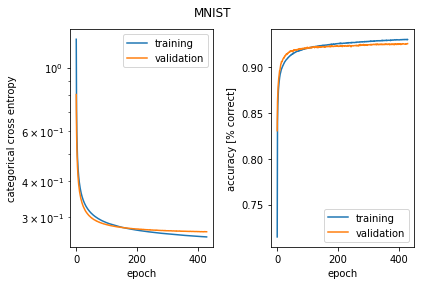

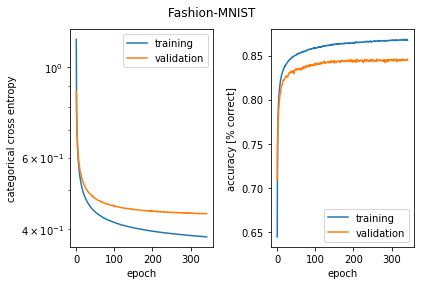

In [16]:
standard, fashion = 'MNIST', 'Fashion-MNIST'

_ = plot_history(histories_2[standard], title=standard)
_ = plot_history(histories_2[fashion], title=fashion)

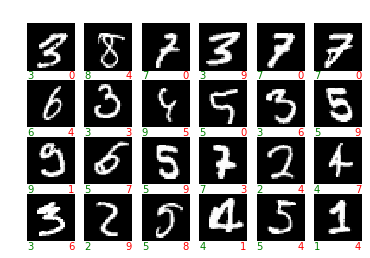

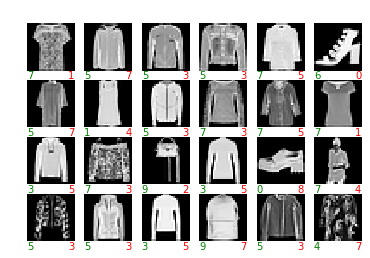

In [17]:
# Plot missmatches:
(_, y_train_c), (_, y_test_c) = mnist.load_data()
(_, y_fashion_train_c), (_, y_fashion_test_c) = fashion_mnist.load_data()

tmp = [('MNIST', _, x_test, _, y_test_c), 
            ('Fashion-MNIST', _, x_fashion_test, _, y_fashion_test_c)]
missmatches = {}

for name, _, input_test, _, output_test in tmp:
    missmatches[name] = []
    
    # predictions
    yhat_test = models_2[name].predict(input_test)   
    # Change predictions format 
    predictions = yhat_test.argmax(axis=1)
    for i, pred in enumerate(predictions):
        if pred != output_test[i]:
            missmatches[name].append(i)
    if name == 'MNIST':      
        plot_some_samples(input_test, (output_test+9)%10, (yhat_test+9)%10, missmatches[name])
    else:
        plot_some_samples(input_test, output_test, yhat_test, missmatches[name])

Answer to question 10:

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [18]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [19]:
# dropout in the hidden layers with weight constraint
def create_model_exercice3(lr, optimizer, num_hidden_units=128, input_dim=784, num_classes=10):
    # Create model
    model = Sequential()
    model.add(Dense(num_hidden_units, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=optimizer, 
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [ ]:
# choose a minibatch of size 128
batch_size = 128
# Use one hidden layer with 128 units
num_hidden_units = 128
# Size of input
input_dim = len(x_train[0])
# Fit the model for 50 epochs
epochs = 50

# Define different learning rates
lrs = [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1] 
# Define optimization strategies
optimizers = [SGD(), Adam()]

In [ ]:
# save histories, summaries and scores
histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    # Learn with various parameters
    for lr in lrs:
        # Define level one keys
        key_lr = 'lr={}'.format(str(lr))
        histories[name][key_lr], summaries[name][key_lr], scores[name][key_lr] = {}, {}, {}

        for optim in optimizers:
            # Set learning rate
            optim = optim.from_config({'lr':lr})
            # Get model
            model = create_model_exercice3(lr, optim)
            # Fit model
            history = model.fit(input_train, target_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=0,
                                validation_data=(input_test, target_test))
            
            
            # Get optimizer name
            key_optim = optim.__class__.__name__
            # Update dictionnaries
            histories[name][key_lr][key_optim] = history
            summaries[name][key_lr][key_optim] = model.summary
            # Update scores
            test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
            scores[name][key_lr][key_optim] = {}
            scores[name][key_lr][key_optim]['test_loss'] = test_loss
            scores[name][key_lr][key_optim]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice3/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [20]:
# Load path
load_path = Path('./save/exercice3/')
# Load histories
histories_3 , summaries_3, scores_3 = load(load_path)

In [21]:
# Use the summary method to display your model in a compact way.
mnist, sgd, adam = 'MNIST', 'SGD', 'Adam'
for name in summaries_3:
    for lr in summaries_3[name]:
        print(name, lr, sgd, summaries_3[name][lr][sgd](), '\n')
        print(name, lr, adam, summaries_3[name][lr][adam](), '\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
MNIST lr=0.01 SGD None 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
MNIST lr=0.01 Adam None 

_____________

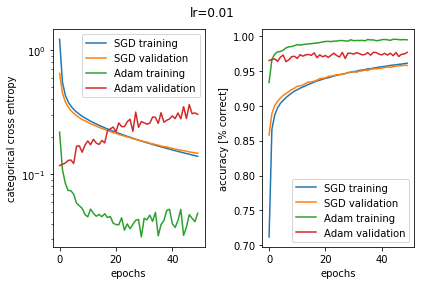

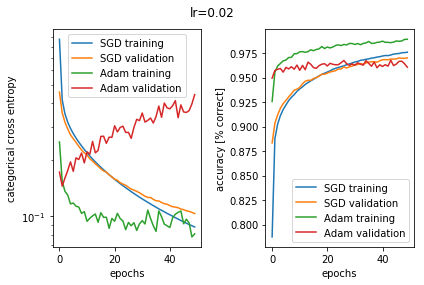

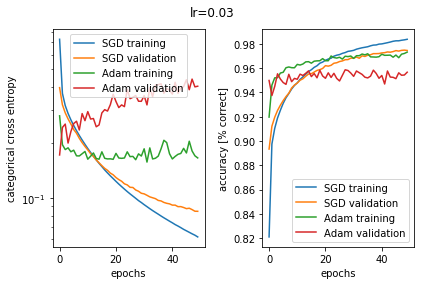

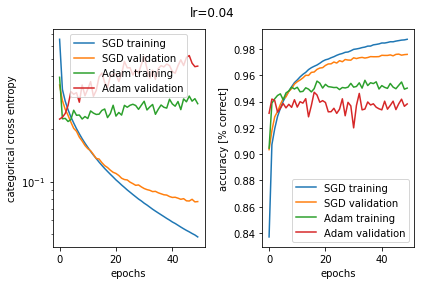

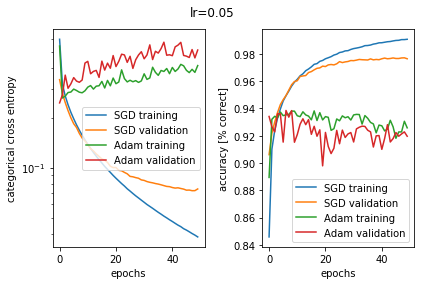

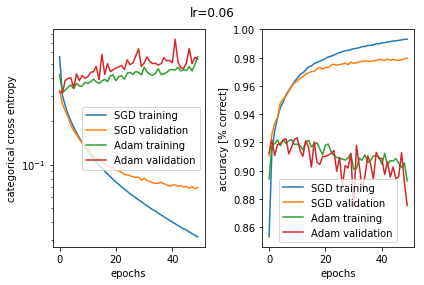

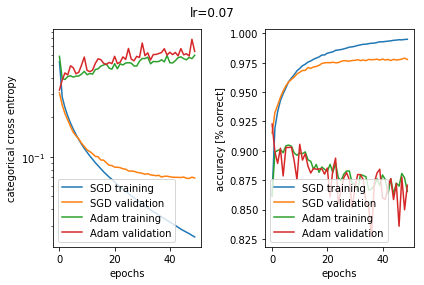

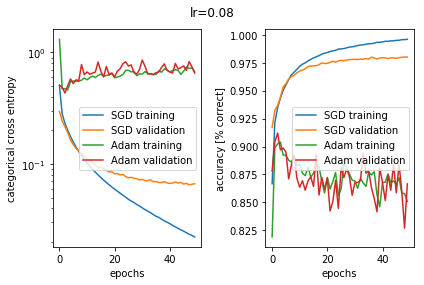

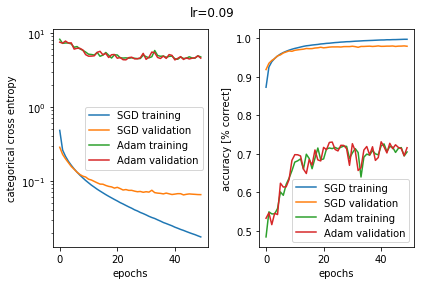

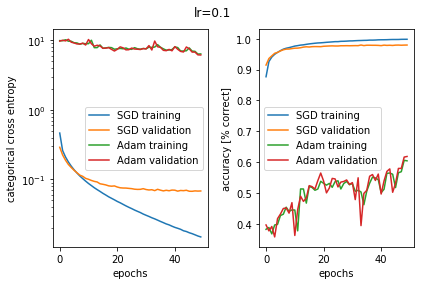

In [22]:
# Plot the learning curves of SGD together with the learning curves of Adam in the same figure
mnist, sgd, adam = 'MNIST', 'SGD', 'Adam'
for lr in histories_3[mnist]:
    # Plot histories
    comparison_plot(histories_3[mnist][lr][sgd], histories_3[mnist][lr][adam], sgd, adam, lr)        

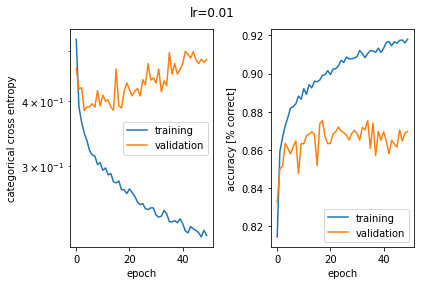

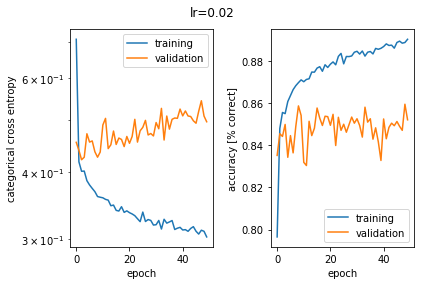

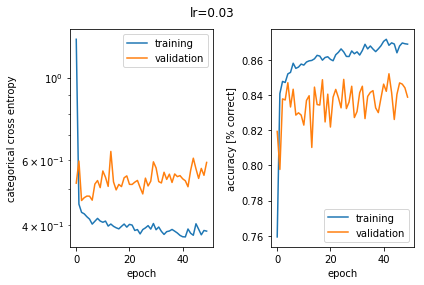

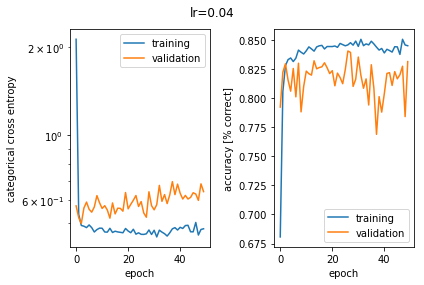

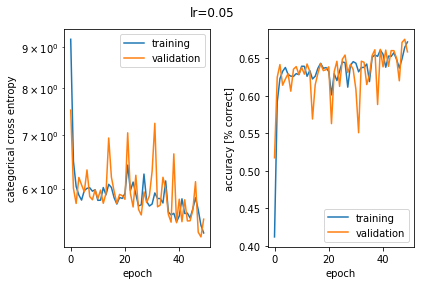

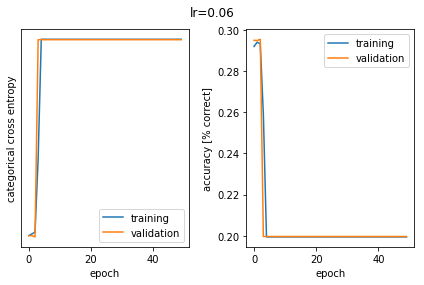

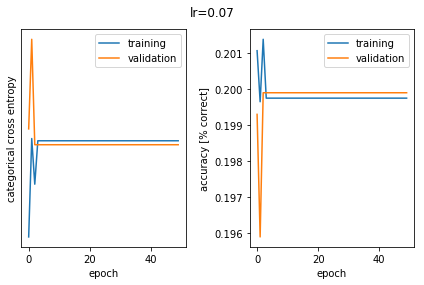

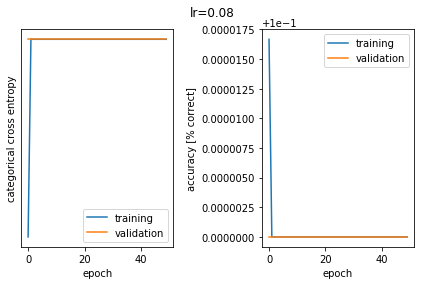

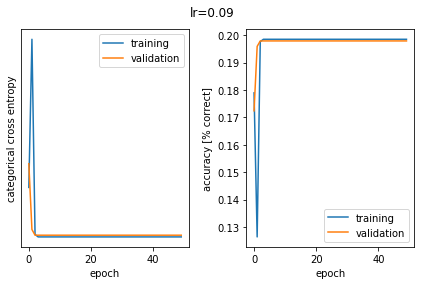

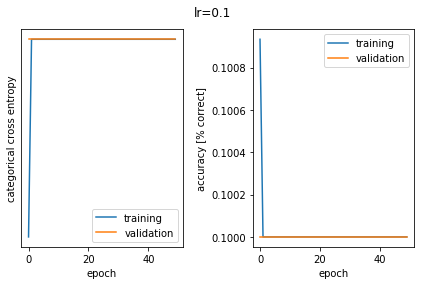

In [23]:
# Plot the learning curves on Fashion-Mnist using Adam optimizer 
fashion, adam = 'Fashion-MNIST', 'Adam'
for lr in histories_3[fashion]:
    plot_history(histories_3[fashion][lr][adam], lr)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is very small, then the algorithm overfits more since it converges faster to a maximum on the traning data.

B) If the learning rate is very low, then the algorithm overfits less since it converges slower to a maximum on the traning data.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: he adam optimizer starts overfitting after around 17 epochs, when the time when the training error decreases and the test error increases.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The accuracy graph is less useful for determining when the graph is overfitting. This is because the loss curves measure the loss in terms of probabilities, while the accuracy only counts the number of correctly predicted labels. Therefore, the accuracy graph remains flat while the loss curve starts slowly increasing because of overfitting.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [24]:
def create_model_exercice4(num_hidden_units, lr=0.01, input_dim=784, num_classes=10):
    # Create model
    model = Sequential()
    model.add(Dense(num_hidden_units, activation='relu', input_dim=input_dim)) # Use the relu activation for the hidden layer
    model.add(Dense(num_classes, activation='softmax')) # Use the softmax activation for the output layer
    
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=Adam(lr=lr), # You may use the Adam optimizer
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [25]:
def prepare_best_metrics_plot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_best_metrics_plot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_best_metrics(ys, xs, title):
    fig, ax1, ax2 = prepare_best_metrics_plot(title, 'hidden units')
    ax1.plot(xs, ys['MNIST']['best_val_loss'], label = "MNIST")
    ax1.plot(xs, ys['Fashion-MNIST']['best_val_loss'], label = "Fashion-MNIST")
    ax2.plot(xs, ys['MNIST']['best_val_acc'], label = "MNIST")
    ax2.plot(xs, ys['Fashion-MNIST']['best_val_acc'], label = "Fashion-MNIST")
    finalize_best_metrics_plot(fig, ax1, ax2)
    return fig

In [ ]:
# For more accurate estimates of the SGD
batch_size = 128
# Sufficiently large for earlyStopping to occur
epochs = 100

# hidden units 
num_hidden_units = [32, 64, 128, 512, 1024]

In [ ]:
# save histories, summaries and scores
histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    
    for num in num_hidden_units:
        # Get model
        model = create_model_exercice4(num)    
        # Train the model
        history = model.fit(input_train, target_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(input_test, target_test))


        # Update histories and summaries
        key_hu = 'num_hidden_units={}'.format(str(num))
        histories[name][key_hu], summaries[name][key_hu] = history, model.summary      
        # Update scores
        test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
        scores[name][key_hu] = {}
        scores[name][key_hu]['test_loss'] = test_loss
        scores[name][key_hu]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice4/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [26]:
# Load path
load_path = Path('./save/exercice4/')
# Load histories
histories_4 , summaries_4, scores_4 = load(load_path)

In [27]:
# Plot the best validation loss and accuracy versus the number of hidden neurons
ys = {}
for name in histories_4:
    ys[name] = {}
    
    best_val_acc, best_val_loss = [], []
    for key_num_hidden_units in histories_4[name]:
        # Get best validation accuracy
        acc = max(histories_4[name][key_num_hidden_units].history['val_acc'])
        # Get best validation loss
        loss = min(histories_4[name][key_num_hidden_units].history['val_loss'])
        # Append result
        best_val_acc.append(acc), best_val_loss.append(loss)
        
    ys[name]['best_val_acc'], ys[name]['best_val_loss'] = best_val_acc, best_val_loss
    
xs = [32, 64, 128, 512, 1024]

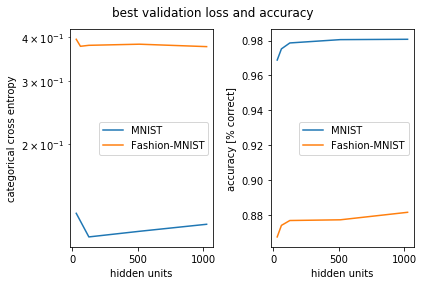

In [28]:
a = plot_best_metrics(ys, xs, 'best validation loss and accuracy')

Answer to question 2: 

For Both Datasets: 

We can see that the validation accuracy tends to increase as a function of the number of neurons in the hidden layer. Since the accuracy increases, the neural network becomes a better approximator for the real function that we try to model. This is in accordance with the general approximation theorem, which states that any continious function could be approximated with a finite number of neurons in the hidden layer, however the number of neurons needed might be exponential.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [29]:
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l1, l2

from distutils.util import strtobool

In [30]:
def create_model_exercice5(num_hidden_units=50, lr=0.01, input_dim=784, num_classes=10,
                           regularizer=None, batch_norm=False, dropout=False):
    # Create model
    model = Sequential()
    
    # Hidden Layer
    if regularizer is None:
        model.add(Dense(num_hidden_units, activation='linear', input_dim=input_dim))
    else:
        model.add(Dense(num_hidden_units, activation='linear', kernel_regularizer=regularizer, 
                        bias_regularizer=regularizer, input_dim=input_dim))
    model.add(Activation('relu'))
    # Batch normalization
    if batch_norm:
        model.add(BatchNormalization())
    # Dropout    
    if dropout:
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=Adam(lr=lr), # You may use the Adam optimizer
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [31]:
batch_size = 128
epochs = 100

# Define different regularizers
my_regularizers = {'L0': None, 'L1': l1(0.01), 'L2': l2(0.01)}
# Use batch normalization ?
batch_norm = [False, True] 
# Use dropout ?
dropout = [False, True]

In [ ]:
# save histories, summaries, and scores
histories, summaries, scores = {}, {}, {}
# Learn with various parameters
for reg_type in my_regularizers:
    # Create regularization entry
    histories[reg_type], summaries[reg_type], scores[reg_type] = {}, {}, {}
    for with_batch_norm in batch_norm:
        # Create batch_norm entry
        key_bn = 'batch_norm={}'.format(str(with_batch_norm))
        histories[reg_type][key_bn], summaries[reg_type][key_bn], scores[reg_type][key_bn] = {}, {}, {}
        for with_dropout in dropout:
            # Get model
            model = create_model_exercice5(regularizer=my_regularizers[reg_type], batch_norm=with_batch_norm, dropout=with_dropout)
            # Fit model
            history = model.fit(x_fashion_train, y_fashion_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_fashion_test, y_fashion_test))

            # Add history an summary values
            key_dp = 'dropout={}'.format(str(with_dropout))
            histories[reg_type][key_bn][key_dp], summaries[reg_type][key_bn][key_dp] = history, model.summary
            # Save scores
            test_loss, test_acc = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
            scores[reg_type][key_bn][key_dp] = {}
            scores[reg_type][key_bn][key_dp]['test_loss'] = test_loss
            scores[reg_type][key_bn][key_dp]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice5/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [32]:
# Load path
load_path = Path('./save/exercice5/')
# Load histories
histories_5 , summaries_5, scores_5 = load(load_path)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


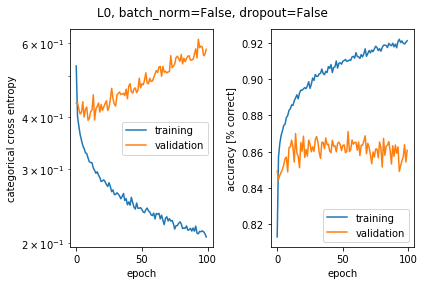

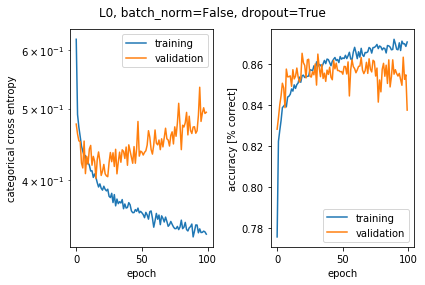

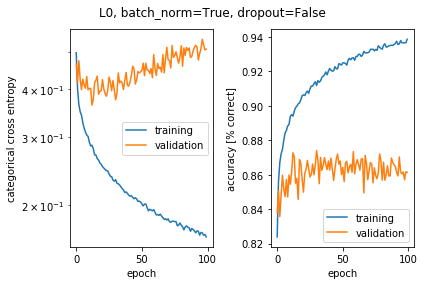

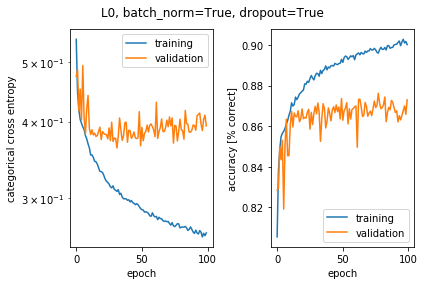

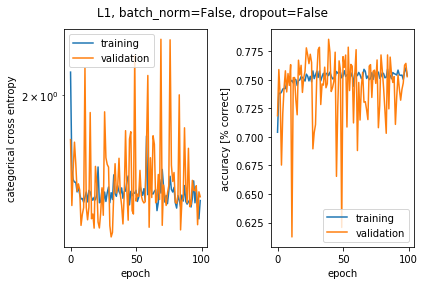

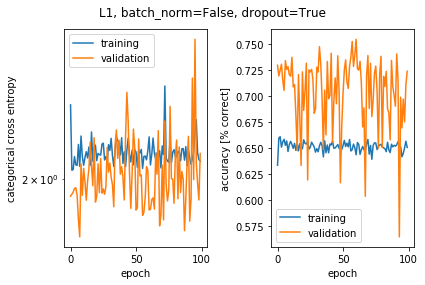

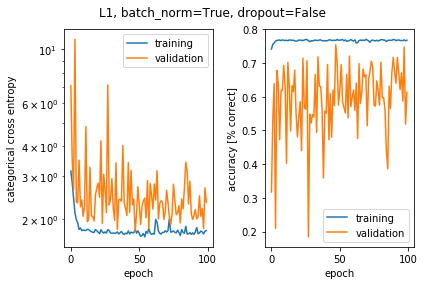

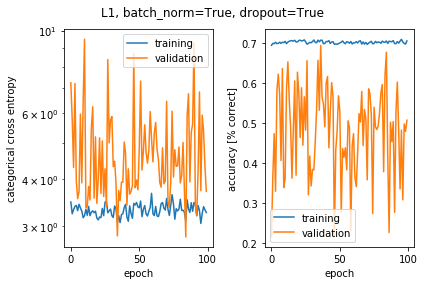

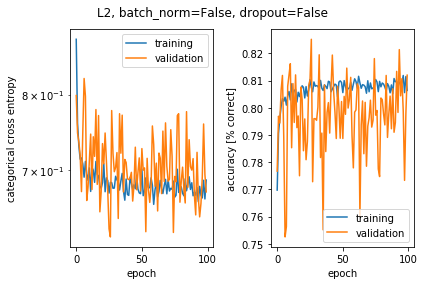

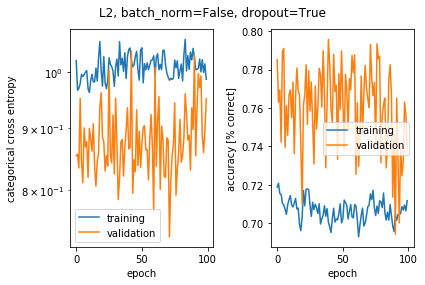

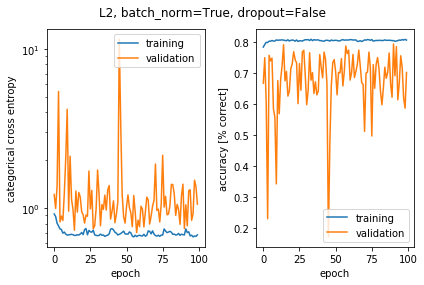

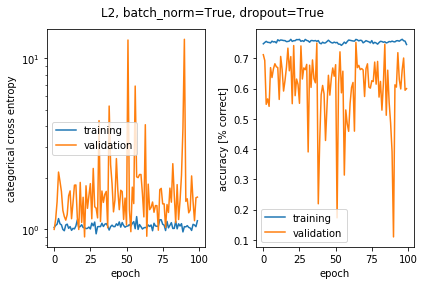

In [33]:
# Plot the learning curves of all trained models
fashion, adam = 'Fashion-MNIST', 'Adam'
for regularizer in histories_5:
    for batch_norm in histories_5[regularizer]:
        for dropout in histories_5[regularizer][batch_norm]:
            plot_history(histories_5[regularizer][batch_norm][dropout], '{}, {}, {}'.format(regularizer, batch_norm, dropout))

In [34]:
# Find best performing model based on test accuracy
best_regularizer, best_batch_norm, best_dropout = None, None, None
max_test_acc = -1
for regularizer in scores_5:
    for batch_norm in scores_5[regularizer]:
        for dropout in scores_5[regularizer][batch_norm]:
            curr_test_acc = scores_5[regularizer][batch_norm][dropout]['test_acc']
            if curr_test_acc > max_test_acc:
                max_test_acc = curr_test_acc
                best_regularizer = regularizer
                best_batch_norm = batch_norm
                best_dropout = dropout

In [35]:
# Here are some characteristics of the best performing model
best_regularizer, best_batch_norm, best_dropout

('L0', 'batch_norm=True', 'dropout=True')

In [37]:
# Fit your best performing model also to MNIST
# for having a reference for the next exercise.

# Get model
best_model = create_model_exercice5(regularizer=my_regularizers[best_regularizer], 
                               batch_norm=strtobool(best_batch_norm.split('=')[1]), 
                               dropout=strtobool(best_dropout.split('=')[1]))
# Fit model
best_history = best_model.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 148us/step - loss: 0.3010 - acc: 0.9095 - val_loss: 0.1547 - val_acc: 0.9524
Epoch 2/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1924 - acc: 0.9412 - val_loss: 0.1257 - val_acc: 0.9611
Epoch 3/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1592 - acc: 0.9511 - val_loss: 0.1273 - val_acc: 0.9597
Epoch 4/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1403 - acc: 0.9565 - val_loss: 0.1123 - val_acc: 0.9665
Epoch 5/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1326 - acc: 0.9579 - val_loss: 0.1208 - val_acc: 0.9631
Epoch 6/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.1260 - acc: 0.9609 - val_loss: 0.0988 - val_acc: 0.9709
Epoch 7/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1172 - acc: 0.9624 - val_loss: 0.0965 -

60000/60000 [==============================] - 2s 32us/step - loss: 0.0541 - acc: 0.9816 - val_loss: 0.1071 - val_acc: 0.9720
Epoch 60/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0547 - acc: 0.9819 - val_loss: 0.1170 - val_acc: 0.9735
Epoch 61/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0526 - acc: 0.9826 - val_loss: 0.1045 - val_acc: 0.9746
Epoch 62/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0546 - acc: 0.9817 - val_loss: 0.1087 - val_acc: 0.9703
Epoch 63/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0537 - acc: 0.9818 - val_loss: 0.1086 - val_acc: 0.9720
Epoch 64/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0537 - acc: 0.9817 - val_loss: 0.1033 - val_acc: 0.9742
Epoch 65/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0522 - acc: 0.9824 - val_loss: 0.1043 - val_acc: 0.9753
Epoch 66/100
60000/60000 [==============

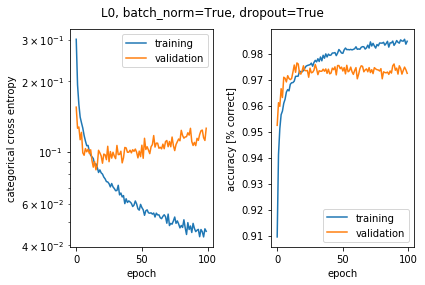

In [38]:
# Plot the resulting learning curves.
a = plot_history(best_history, '{}, {}, {}'.format(best_regularizer, best_batch_norm, best_dropout))

Answer to question 2 (comments): 

The accuracy using batch_norm and dropout is a bit better than for te standard model (>86% vs <86%). We can observe that the accuracy of the model with batch_norm and dropout remains more or less the same on average since the very first stages of training. Both models tend to overfit the data. However, from the error plots we can observe that the 'best' model overfits less.

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [39]:
from keras import backend as K

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape the input images to image format (adding channel dimension) and rescale the data into the range [0,1].

In [41]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

In [42]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [43]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], img_rows, img_cols, 1)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [44]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= np.max(x_train)
x_test /= np.max(x_test)

x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= np.max(x_fashion_train)
x_fashion_test /= np.max(x_fashion_test)

In [45]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples\n')

print('x_fashion_train shape:', x_fashion_train.shape)
print(x_fashion_train.shape[0], 'train fashion samples')
print(x_fashion_test.shape[0], 'test fashion samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples

x_fashion_train shape: (60000, 28, 28, 1)
60000 train fashion samples
10000 test fashion samples


In [46]:
# dropout in the hidden layers with weight constraint
def create_model_exercice6(kernel_size=(3, 3), strides=(1, 1), dropout=False, pooling=False):
    # Create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size,
                     strides=strides,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=kernel_size,
                     strides=strides,
                     activation='relu'))
    if pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [ ]:
# Efficient gradient updates
batch_size = 128
# 10 digits do learn
num_classes = 10
# define number of epochs
epochs = 50

In [ ]:
histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    # Get the model
    model = create_model_exercice6(dropout=True, pooling=True)
    # Fit the model
    history = model.fit(input_train, target_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(input_test, target_test))

    # Update histories and summaries
    histories[name], summaries[name] = history, model.summary
    # Update scores
    test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
    scores[name] = {}
    scores[name]['test_loss'] = test_loss
    scores[name]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice6/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [47]:
# Load path
load_path = Path('./save/exercice6/')
# Load histories
histories_6 , summaries_6, scores_6 = load(load_path)

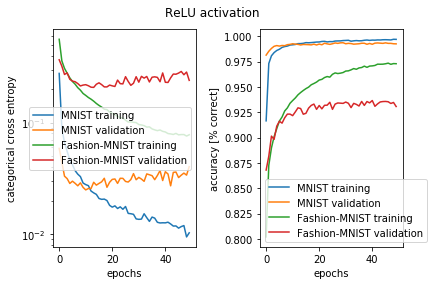

In [48]:
# Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST
mnist, fashion = 'MNIST', 'Fashion-MNIST'
a = comparison_plot(histories_6[mnist], histories_6[fashion], mnist, fashion, 'ReLU activation')        

In [49]:
# Output scores for both datasets
print('{: >13}: {}'.format(mnist, scores_6[mnist]))
print('{: >13}: {}'.format(fashion, scores_6[fashion]))

        MNIST: {'test_loss': 0.04027398465529345, 'test_acc': 0.9924}
Fashion-MNIST: {'test_loss': 0.23982352925539016, 'test_acc': 0.9306}


Answer to question 3: 

For both datasets the CNN model outperforms in terms of accuracy the best deep network designed so far. The validation error is also lower with CNNs.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [50]:
# dropout in the hidden layers with weight constraint
def create_model_exercice7(kernel_size=(3, 3), strides=(1, 1), dropout=False, pooling=False, batch_norm=False):
    # Create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size,
                     strides=strides,
                     activation='sigmoid',
                     input_shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=kernel_size,
                     strides=strides,
                     activation='sigmoid'))
    if batch_norm:
        model.add(BatchNormalization())
    if pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [ ]:
# Efficient gradient updates
batch_size = 128
# 10 digits do learn
num_classes = 10
# define number of epochs
epochs = 50

# args
batch_norm = [False, True]

In [ ]:
histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    for bool_ in batch_norm:       
        # Get the model
        model = create_model_exercice7(dropout=True, pooling=True, batch_norm=bool_)
        # Fit the model
        history = model.fit(input_train, target_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(input_test, target_test))

        key_bn = 'batch_norm={}'.format(str(bool_))
        histories[name][key_bn], summaries[name][key_bn] = history, model.summary       
        # Update scores
        test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
        scores[name][key_bn] = {}
        scores[name][key_bn]['test_loss'] = test_loss
        scores[name][key_bn]['test_acc'] = test_acc

In [ ]:
# Save path
save_path = Path('./save/exercice7/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [51]:
# Load path
load_path = Path('./save/exercice7/')
# Load histories
histories_7 , summaries_7, scores_7 = load(load_path)

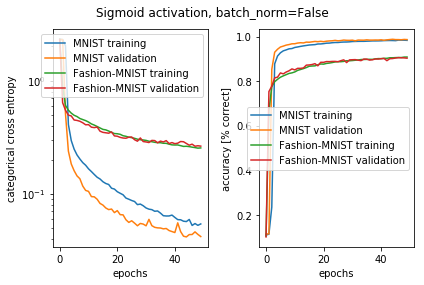

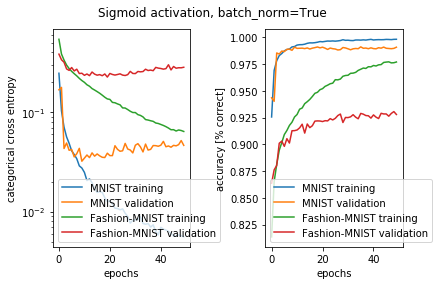

In [52]:
# Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST
mnist, fashion = 'MNIST', 'Fashion-MNIST'
for batch_norm in histories_7[mnist].keys():
    a = comparison_plot(histories_7[mnist][batch_norm], histories_7[fashion][batch_norm], mnist, fashion, 'Sigmoid activation, {}'.format(batch_norm))        

In [53]:
# Output scores for both datasets
reform = {(outerKey, middleKey): values for outerKey, middleDict in scores_7.items() for middleKey, values in middleDict.items()}
a = pd.DataFrame.from_dict(reform)
a

MNIST                    Fashion-MNIST                
          batch_norm=False batch_norm=True batch_norm=False batch_norm=True
test_acc            0.9866        0.990800          0.90310        0.927900
test_loss           0.0418        0.046439          0.26321        0.283106

Answer to question 1: Training and validation curves are very close to each other whether for loss or accuracy plot. 

Answer to question 2: The network can achieve the same performances than the ReLU-CNN based on the observed accuracy values which very close for both models
